- Input parameters

In [23]:
import torch

# main input file
input_file = './example_data/128.txt'

# default parameters
batch_size = 2
kernel_intensity = 4
target_resolution = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

- Main code

In [ ]:
import time
from torch.utils.data import DataLoader
from src.utils.imagedata import SpectrumImageDataset, collate_fn
from src.utils.spectrum import read_spectrum, save_spectrum, denorm_spectrum
from src.utils.trainer import SwinIRTrainer
from src.utils.visualize import super_resolution_summary
from src.SwinIR.models.network_swinir import SwinIR
from scipy.ndimage import convolve
import numpy as np

upscale = 4

## SwinIR classical SR DF2K model
#model = SwinIR(upscale=4, in_chans=3, img_size=64, window_size=8, img_range=1., 
#               depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
#               mlp_ratio=2, upsampler='pixelshuffle', resi_connection='1conv')
#pt_dict = torch.load('./src/SwinIR/model_zoo/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth', map_location='cpu')['params']

## SwinIR classical SR DIV2K model
model = SwinIR(upscale=upscale, in_chans=3, img_size=48, window_size=8, img_range=1., 
               depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
               mlp_ratio=2, upsampler='pixelshuffle', resi_connection='1conv')
pt_dict = torch.load('./src/SwinIR/model_zoo/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth', map_location='cpu')['params']

# load model parameters
md_dict = model.state_dict()
md_dict.update(pt_dict)
model.load_state_dict(md_dict)
model.to(device)
trainer = SwinIRTrainer(model=model, opt=None, device=device)

# read data
x_inp, y_inp = read_spectrum(input_file)
x = x_inp.copy()
y = y_inp.copy()

dataset = SpectrumImageDataset(upscale_factor=4, data_augmentation=False)
k = kernel_intensity
kernel  = np.array([[0, -k*0.25, 0], [-k*0.25, 1+k, -k*0.25], [0, -k*0.25, 0]])

# Super resolution loop until 
for i in range(1,20):
    t1=time.time()
    dataset.from_data(x, y)
    data = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    out = trainer.pred(data)['None_None']
    x = out['x']
    y = np.stack([convolve(_y, kernel) for _y in denorm_spectrum(out['pred'], out['vmin'], out['vmax'])], axis=0)
    m = upscale ** i
    t = time.time() - t1
    print('Mag.: {}x  / Dim.: {}x{}x{}  / min intensity: {:.2f}  / max intensity: {:.2f}  / Elapsed: {}{}'.format(m, *y.shape, out['vmin'], out['vmax'], f'{t//60:.0f}m' if t > 60 else '', f'{t%60:.2f}s' if t < 10 else f'{t%60:05.2f}s'))
    if y.shape[1] >= target_resolution:
        break

- saving final output

In [11]:
# final output: x, y
save_spectrum(x, y, fn=input_file.replace('.txt',f'_{m}x.txt'))

- visualization

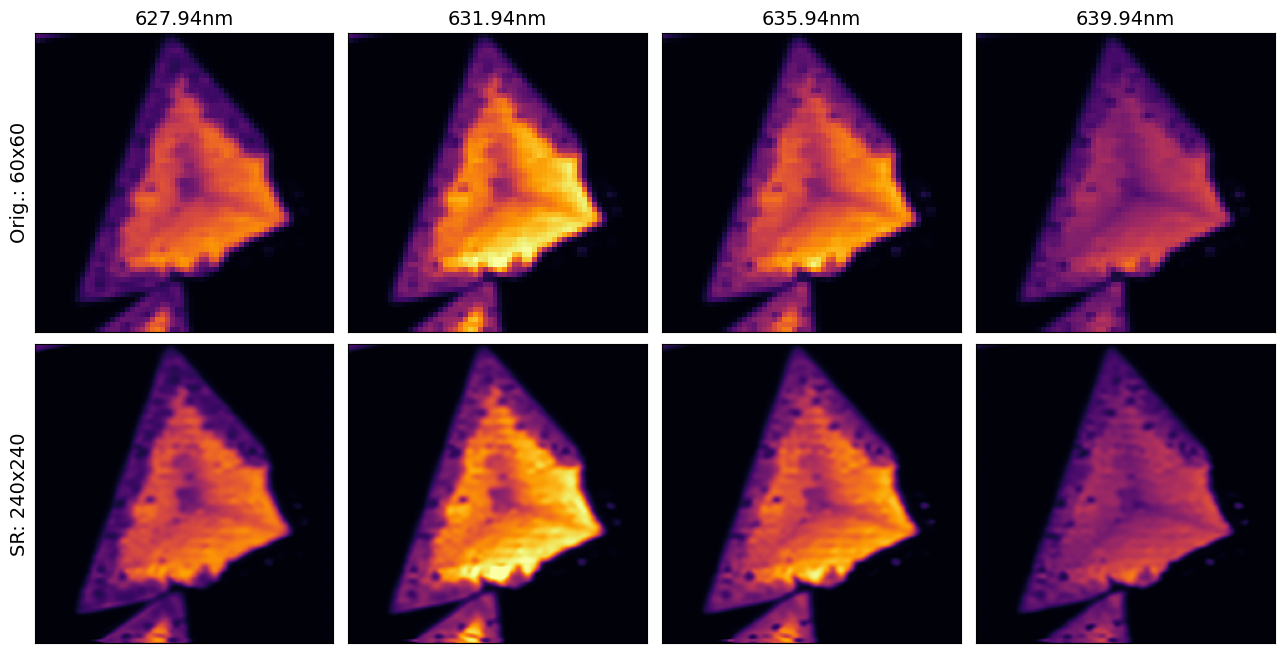

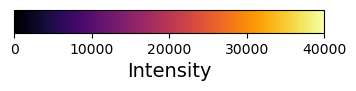

In [26]:
_ = super_resolution_summary(x, y, x_inp, y_inp, locs=[628, 632, 636, 640], intensity_range=[0,40000])